# t-SNE Cell Line Clustering with Phosphorylation Data
I'll use t-SNE to get an overview of cell line clustering before and after different normalization procedures for the CST data. I will judge the quality of clustering based on the following criteria: 
* Cell lines should cluster based on their histology, NSCLC and SCLC
* The NSCLC and SCLC clusters should be well separated 
* Each histological cluster should be compact
* Cell lines should not cluster based on plex

### Imports and Function Definitions

In [1]:
from copy import deepcopyd
import tsne_fun
from clustergrammer import Network
net = deepcopy(Network())

# Clustering Original Data (including missing values)
First, I will cluster the cell lines (using t-SNE) based on the original phosphorylation data - including phosphorylation with missing values. Since cell lines from the same plex share the same missing data we would expect that including missing data (which is ultimately set to zeros) will cause the cell lines to artificially cluster based on their plexes. 

(5798, 45)


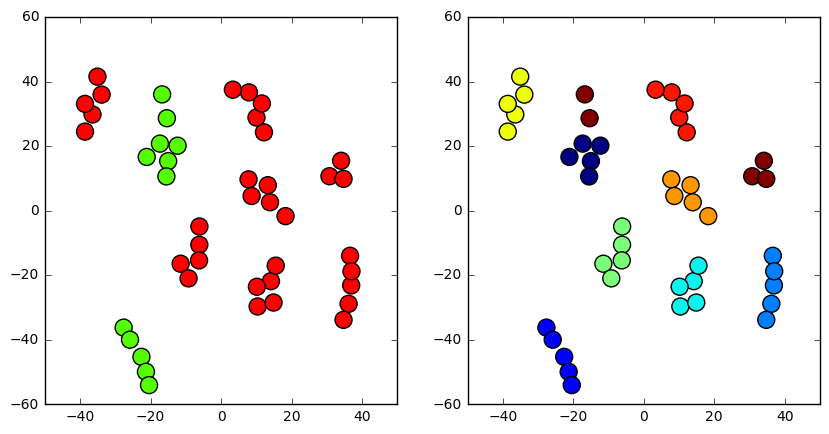

In [20]:
tsne_fun.normalize_and_make_tsne()

### Conclusions
The left tsne plot shows cell lines colored based on histology, SCLC is green and NSCLC is red. The cell cell lines appear to largely cluster based on shared histology. The right tsne plot shows cell lines colored based on their plex - there are 5 cell lines per plex. The cell lines cluster almost exclusively into groups that belong to the same plex. 

From these figures we can see that two plexes are composed of entirely SCLC cell lines. We can also see that there is a large batch effect that needs to be corrected. The clusters of cell lines within a single plex-batch frequently stretched out into 'lines'. This stretching of the plex-clusters is likely due to the systematic differences in the cell line distributions (see boxplots from [CST_PTM_Data_Overview.ipynb](http://localhost:8889/notebooks/notebooks/CST_PTM_Data_Overview.ipynb)). The two primary drivers of cell line clustering appear to be 1) plex and 2) systematic differences in cell line distributions. 

# Normalization and Filtering Procedures
We will try the following procedures individually and in combination and check their effect on cell line clustering
* Normalize the cell line distributions so that they are more similar (e.g. quantile normalization)
* Z-score the PTM distributions to highlight differences between the cell lines
* Filter out PTMs with missing data

# Clustering with Column Quantile Normalization (QN)
Based on the figures from [CST_PTM_Data_Overview.ipynb](http://localhost:8889/notebooks/notebooks/CST_PTM_Data_Overview.ipynb) it is clear that the distributions of PTM measurements in the cell lines are systematically different. Since the differnces in the PTM distributions in the cell lines are larger than we would expect biologically we can try to use a normalization procedure to bring these distributions closer to eachother. Here I will use Quantile Normalization (more specifically a slightly modified version set up to deal with the missing values) on the cell line columsn and see what effect this has on the cell line clustering. 

quantile normalize columns
(5798, 45)


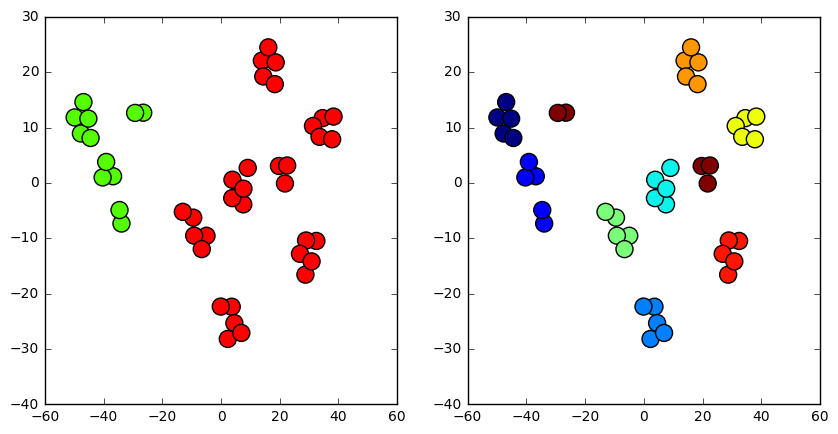

In [21]:
tsne_fun.normalize_and_make_tsne(qn_col=True)

### Conclusions
After applying quantile normalization to the cell lines the cell lines still largely cluster based on histology and plex. A noticeable difference after QN-column normalization is that the plex-groups are no longer stretched into 'lines' and now form compact clusters. This is likely because QN-column normalization has removed the systematic differences in cell line distributions within a plex, which causes them to cluster more compactly.

# Clustering with Row Z-score
We can see from heatmaps of the original PTM data that PTMs largely have consistent values across all cell lines, e.g. if a PTM is up-regulated in one cell line then it is likely up-regulated in all cell lines and vice-versa. We can Z-score the PTM rows to highlight the relative differences in PTM levels across all cell lines. Here we will see how this affects cell line clustering.

zscore rows
(5798, 45)


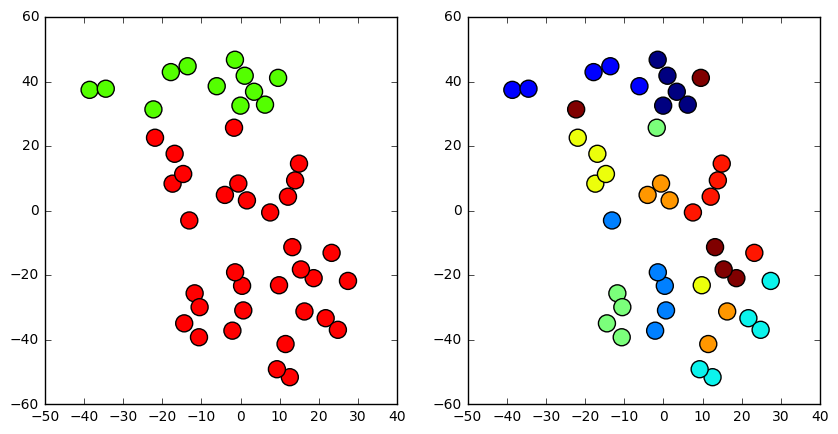

In [22]:
tsne_fun.normalize_and_make_tsne(zscore_row=True)

### Conclusions
Z-scoring the rows alone appears to worsen cell line clustering based on histology (left) and also worsen cell line clustering based on plexes. Since Z-scoring of the rows was performed before quantile normalization of the columns This will result in cell lines with uniformly high PTMs and cell lines with uniformly low PTMs - I suspect that the cell lines are arranged according to their average PTM values in the above plots. 

# Clustering with Column QN and Row Z-score
The normalization procedure that should be performed is one that first removes the systematic bias in the cell line distributions and then highlights the relative differences in PTM levels across the cell lines. Here we will first perform cell line column quantile normalization (QN) and second perform PTM row Z-score normalization. 

quantile normalize columns
zscore rows
(5798, 45)


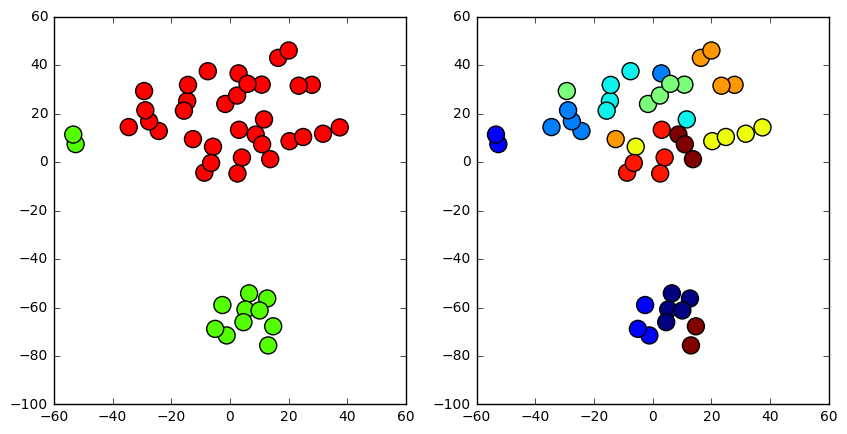

In [23]:
tsne_fun.normalize_and_make_tsne(qn_col=True, zscore_row=True)

### Conclusions: Histology clustering is improved and plexes appear slightly more mixed
On the left we can see a distinct clustering of the cell lines based on their histology, with only two SCLC cell lines not clustering with the others. On the right we can see that the plexes in both SCLC and NSCLC are clustered more closely to eachother and appear more mixed together than in the original plot with no normalization. 

We have not yet removed any PTMs with missing values and doing so should reduce the plex clustering. 

# Clustering with no missing data
Plexes have common missing data, which is why clustering the cell lines using phosphorylation data that has missing data will result in cell lines that cluster based on their plex. We can try clustering the cell lines using only the phosphorylations that have been measured in all cell lines to see if we still see the same pattern of cell line clustering. 

filter PTMs with missing values
(513, 45)


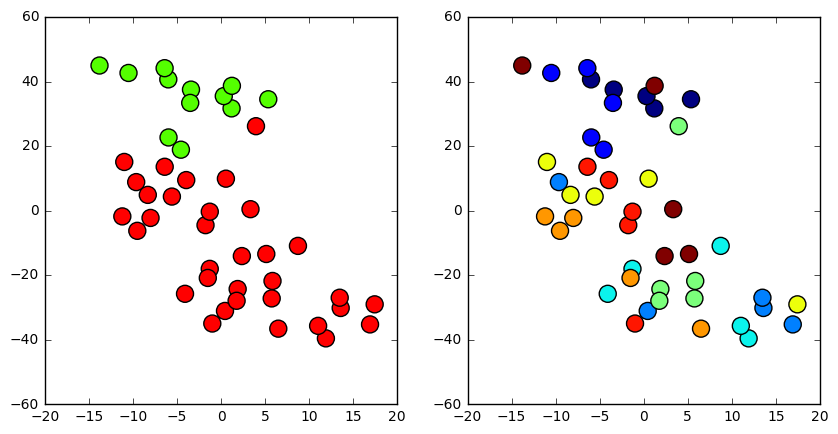

In [25]:
tsne_fun.normalize_and_make_tsne(filter_missing=True)

### Conclusion
Filtering for PTMs (phosphorylations in this case) that are measured in all cell lines leaves us with 513 PTMs. The resulting tsne figure shows that cell lines cluster according to their histology and that their plex clustering is noticeably worse, which is what we expect since missing data drives plex clustering. The cell lines also appear to cluster into three groups: one SCLC group and two NSCLC groups. 

The SCLC cluster appears to be stretched out, which is likely caused by cell line PTM distribution differences. 

# Clustering with no missing data and QN columns
Here I am first performing QN normalization on the entire dataset, 5798 phosphorylations, and then filtering for PTMs that were measured in all cell lines. The results do not appear to change much if filtering is done befor QN (not shown).

quantile normalize columns
filter PTMs with missing values
(513, 45)


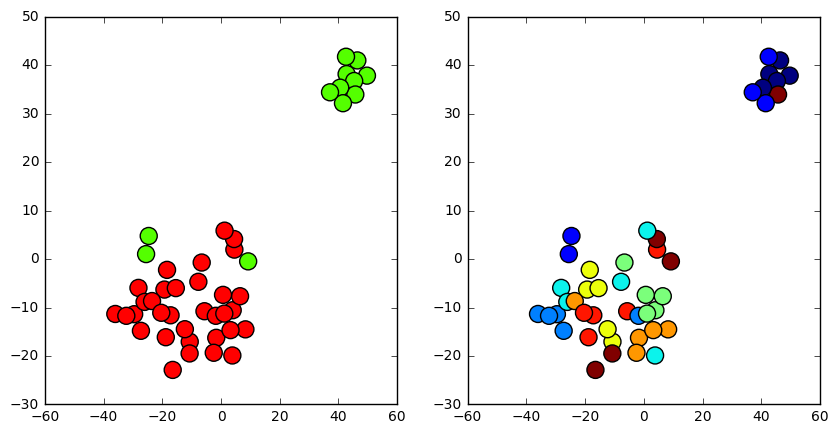

In [26]:
tsne_fun.normalize_and_make_tsne(qn_col=True, filter_missing=True)

### Conclusions
We can see that cell lines cluster according to their histology and plex clustering is noticeably worse, which we expect. The cell lines form two large and very separated clusters which consist of almost exclusively NSCLC and SCLC cell lines. The SCLC cluster is also more compact than the NSCLC cluster. Also the SCLC cluster is more compact than when only PTM filtering is performed (see previous image) becuase the systematic differences in cell line clustering have been removed with QN. 

# Clustering with no missing data and Z-score rows


zscore rows
filter PTMs with missing values
(513, 45)


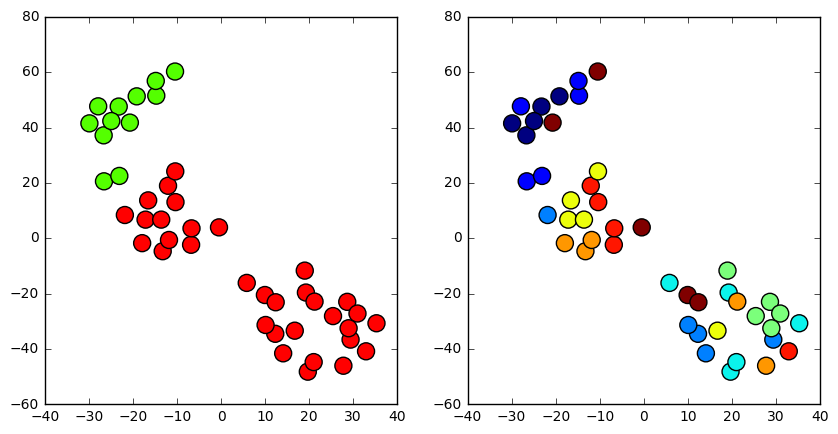

In [27]:
tsne_fun.normalize_and_make_tsne(zscore_row=True, filter_missing=True)

### Conclusions
Z-scoring the PTM-rows and filtering for missing data shows histology clustering and reduced plex clustering. As we had seen with performing Z-score PTM-row normalization alone (without column QN normalization) we get stretched clusters. 

# Clustering with no missing data QN columns and Z-score rows
Finally, can perform QN-column normalization, Z-score row normalization, and only include PTMs that were measured in all cell lines. 

quantile normalize columns
zscore rows
filter PTMs with missing values
(513, 45)


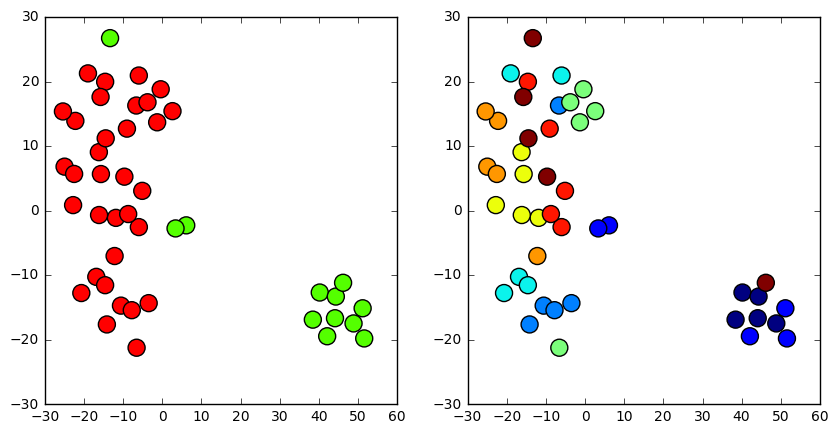

In [28]:
tsne_fun.normalize_and_make_tsne(qn_col=True, zscore_row=True, filter_missing=True)

### Conclusions
With these two normalizations followed by filtering we see clustering based on histology and reduced clustering based on plex. The SCLC cluster is more compact than before (see previous figure) and there is a large separation between the SCLC and NSCLC clusters. It is difficult to compare plex clustering in this figure to the previous figures. However, we can see that NSCLC cell lines form a more compact cluster than they did in the case with PTM filtering alone. 

I would argue that this cluster agrees best with what we would expect biologically for the following reasons:
* NSCLC and SCLC cell lines are very clearly separated
* SCLC cell lines are clustered bery compactly
* NSCLC cell lines are clustered more compactly than in other cases 
* plex clustering is reduced 

